# Traitement des données d'un département

## Description 
Ce document permet de télécharger et traiter les données de la Base de Données *DPE Logements Existants (depuis 2021)* de l'ADEME en ayant recours à l'API avec le module **requests** de Python. Tout le traitement se fait avec **pandas** et **numpy**. 

### 1. Récupération des données
On récupère les données d'un certain département et on le met dans un fichier nommé ***Dpe_dep_{Dep}.csv*** avec ***Dep*** le département choisi. Le fichier n'est normalement pas téléchargé sur la machine, mais sur l'environnement du *Jupyter Notebook*. *(Sinon demandez moi en vrai on regarde pour créer un venv et je vais check comment on fait avec le git)*  
Le processus peut prendre du temps mais une fois que c'est fait vous pouvez travaillez dessus. L'API récupère les lignes par 1000 à chaque requête, l'API nous donne une url ***next*** pour continuer la requête et récupérer les lignes suivantes. On relance donc la requête avec la nouvelle url. On fait ça jusqu'à ce qu'il n'y ait plus d'url next.
Et on le met aussi dans un **pd.DataFrame** ***Dpe_dep***.

### 2. Nettoyage des données
Une fois les données récupérées, la fonction **profile_dataframe** crée un dataframe avec en index les noms des colonnes du ***Dpe_dep*** et en colonne les attributs de ces colonnes : Types des variables (float, str, int,...), Nombre et Pourcentage des valeurs manquantes, le Nombre de Catégories Uniques et la Classe Inférencée (Numérique, Catégorielle,...).

*Catégories Uniques : le nombre de valeurs possibles pour une colonne 
Exemple : etiquette_DPE --> 7 Catégories Uniques = A,B,C,D,E,F,G

On retire les colonnes avec plus de **80%** de valeurs manquantes. 
Pour les colonnes restantes : on transforme les colonnes catégorielles avec **15 ou moins** catégories uniques et on attribue à chaque catégorie un chiffre.  
Exemple : etiquette_DPE --> A-> 1, B-> 2, C-> 3, ... 

Ensuite on enlève les lignes avec trop de valeurs manquantes (>80%).


### 3. Analyse 

ça arrive  
mais faites vos ketru aussi 


## Utilisation

#### Pour changer le département à étudier : 
Dans la cellule ***Configuration de la requête*** : il faut remplacer la variable ***Dep*** --> ça va aussi changer le nom du fichier qui va se créer.  
Si vous avez téléchargé le fichier en ligne, il faut le renommer pour matcher le reste du script ***Dpe_dep_{Dep}.csv*** avec ***Dep*** le département choisi.

#### Erreurs :
Si vous avez une erreur de ce type à la cellule **Récupération des données si fichier inexistant**:

*DtypeWarning: Columns (160,215,217,218,220,222,223) have mixed types. Specify dtype option on import or set low_memory=False.
 dpe_dep= pd.read_csv(fname)*

Ignorez la cellule **Vérification des résultats**.
C'est ok, je sais pas trop c'est quoi mais le fichier existe déjà :)

Et s'il ya une erreur ailleurs bah mdr jsp

  
  
### **PS** : Si vous faites des graphiques, pensez à dl les images si je l'ai pas fait automatiquement :)
### Aussi, vous pouvez dupliquer et renommer le fichier si vous préferez en avoir un par département.

**Importation des modules**

In [183]:
import requests
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import json 
from pprint import pprint
import os.path
import seaborn as sns
import matplotlib.pyplot as plt

**Configuration de la requête** 

In [184]:
# URL de l'API ADEME Data Fair (DPE Logements existants depuis 2021)
URL_DPE = "https://data.ademe.fr/data-fair/api/v1/datasets/dpe03existant/lines"

Dep="75" #Code du département à analyser

#Nom du fichier qui contiendra les données nettoyées
fname=f'Dpe_dep_{Dep}.csv'

#Filtre : 
FILTRE = f'code_departement_ban:{Dep}'

#initialisation des parametres
PARAMETERS = {
        "q_mode":"simple",
        "size": 1000,
        "qs": FILTRE,
    }


**Fonction de récupération des données**

In [185]:
def get_dpe_data(url, params):
    """
    Récupère la première page de données DPE pour Paris (via le code postal 75*).
    """
    #print(f"Tentative de récupération des données DPE pour la commune {Dep}.")
    #print(f"Filtre de recherche (q) utilisé : {params['qs']}")

    #print(url)
    try:
        # Ajout d'un timeout pour éviter les blocages prolongés
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()

        # Si la réponse est vide, on récupère un dict vide pour éviter les exceptions
        data = response.json() if response.content else {}
        lines = data.get('results', [])
        total_count = data.get('total', 'N/A')
        # Utiliser .get() pour éviter KeyError si 'next' est absent
        next_rows = data.get('next', None)

        # Débogage (décommenter si nécessaire)
        #print(f"\n Requête réussie.")
        #print(f"Nombre de résultats récupérés dans cette page : {len(lines)}")
        #print(f"Nombre total de résultats disponibles (estimation Data Fair) : {total_count}")
        #print(f"Next URL: {next_rows}")

        return lines, next_rows

    except ValueError as e:
        # Problème lors du décodage JSON
        print(f"Erreur lors du décodage JSON : {e}")
        return [], False

    except requests.exceptions.HTTPError as e:
        # Gère spécifiquement l'erreur 400 ou la fin de la requête forcée
        print(f"Erreur HTTP détectée : {e}")
        # Si c'est une erreur 400, on considère la pagination comme terminée
        if e.response.status_code == 400:
            print("Arrêt suite à l'erreur 400 (Bad Request).")
        return [], False # Retourne une liste vide et False pour l'échec/arrêt

    except requests.exceptions.RequestException as e:
        # Gère les erreurs de connexion, timeout, etc.
        print(f"Erreur lors de la requête HTTP : {e}")
        return [], False # Retourne une liste vide et False pour l'échec
    

**Récupération des données si fichier inexistant**

In [186]:
existing=False
if os.path.isfile(fname):
    dpe_dep= pd.read_csv(fname)
    existing=True

else: 
    all_rows=[]
    
    next_url=URL_DPE
    
    while True :
        
        rows,next_url= get_dpe_data(next_url, PARAMETERS) #rows=les nouvelles lignes, next_url= la nouvelle url
        #print(next_url)
    
        if not next_url:
            # Arrêt si la fonction a rencontré une erreur HTTP (y compris 400)
            break
    
        if not rows:
            # Arrêt si la page est vide (fin naturelle des données)
            print("Aucune ligne trouvée. Fin.")
            break
        
        
        all_rows.extend(rows)
        PARAMETERS=None
        
    dpe_dep= pd.DataFrame(all_rows)
    dpe_dep.to_csv(fname,index=False)
    

Erreur lors de la requête HTTP : ("Connection broken: ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None)", ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None))


**Vérification des résultats**

In [187]:
# Afficher une vérification
if all_rows:
    departements_recuperes = set(line.get('code_departement_ban') for line in all_rows)
    
    print("\n--- Vérification des codes départementaux et postaux ---")
    if len(departements_recuperes) == 1 and "75" in departements_recuperes:
        print("Succès : Seul le département 75 a été trouvé.")
    else:
        print(f"Attention : Les départements trouvés sont : {departements_recuperes}")

    # Afficher les 3 premières lignes pour inspecter les codes postaux
    print("\n--- Aperçu des 3 premières lignes ---")
    for i, line in enumerate(all_rows[:3]):
        print(f"Ligne #{i+1}: Dép: {line.get('code_departement_ban', 'N/A')}, Code Postal: {line.get('code_postal_ban', 'N/A')}")
        
    print(f"\nTotal des DPE dans la liste : {len(all_rows)}")
else:
    print("\nAucune ligne DPE n'a pu être récupérée.")


--- Vérification des codes départementaux et postaux ---
Succès : Seul le département 75 a été trouvé.

--- Aperçu des 3 premières lignes ---
Ligne #1: Dép: 75, Code Postal: 75013
Ligne #2: Dép: 75, Code Postal: 75007
Ligne #3: Dép: 75, Code Postal: 75007

Total des DPE dans la liste : 530000


**Nettoyage des données**

In [188]:
def profile_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyse un DataFrame pour déterminer le type de données de chaque colonne,
    le nombre de valeurs manquantes (NaN) et le nombre de valeurs uniques.

    Args:
        df: Le DataFrame pandas à analyser.

    Returns:
        Un nouveau DataFrame contenant le profil de chaque colonne.
    """
    
    # Création d'un DataFrame vide pour stocker les résultats de l'analyse
    profile = pd.DataFrame(index=df.columns)
    
    # 1. Type des Variables (dtype)
    profile['Type de Variable'] = df.dtypes
    
    # 2. Nombre de Valeurs Manquantes (NaN)
    profile['Valeurs Manquantes (Count)'] = df.isnull().sum()
    
    # 3. Pourcentage de Valeurs Manquantes
    profile['Valeurs Manquantes (%)'] = (df.isnull().sum() / len(df)) * 100
    
    # 4. Nombre de Catégories Uniques (Cardinalité)
    profile['Nombre de Catégories Uniques'] = df.nunique()
    
    # 5. Type de Données Inférencé (Numérique, Catégorique, Date/Heure)
    def determine_data_class(series, max_unique_ratio=0.1):
        n_unique = series.nunique()
        n_rows = len(series)
        dtype = series.dtype

        # Si le type est déjà datetime
        if pd.api.types.is_datetime64_any_dtype(dtype):
            return 'Date/Heure'
        
        # Si c'est un type numérique
        if pd.api.types.is_numeric_dtype(dtype):
            # Si le nombre de valeurs uniques est inférieur à 10% de la taille, c'est probablement catégorique
            if n_unique / n_rows < max_unique_ratio and n_unique < 50:
                 return 'Numérique/Catégorique'
            return 'Numérique'
        
        # Pour les types objet (string)
        if dtype == 'object' or dtype == 'category':
            # Si peu de valeurs uniques par rapport au total, c'est catégorique
            if n_unique / n_rows < max_unique_ratio:
                return 'Catégorique'
            return 'Texte (ID/Nom)'
        
        return str(dtype) # Type par défaut

    profile['Classe Inférencée'] = df.apply(determine_data_class)
    
    return profile.sort_values(by='Nombre de Catégories Uniques', ascending=False)



In [189]:
# 2. Lancement de la fonction d'analyse
df_profil = profile_dataframe(dpe_dep)

# 3. Affichage du résultat
print("="*60)
print("Analyse de Profil du DataFrame :")
print("="*60)
print(df_profil)
print("\n")


Analyse de Profil du DataFrame :
                                                   Type de Variable  \
numero_dpe                                                   object   
_id                                                          object   
_i                                                            int64   
_rand                                                         int64   
complement_adresse_logement                                  object   
...                                                             ...   
modele_dpe                                                   object   
usage_generateur_n2_ecs_n1                                   object   
code_departement_ban                                         object   
facteur_couverture_solaire_saisi_installation_c...          float64   
_score                                                       object   

                                                    Valeurs Manquantes (Count)  \
numero_dpe                      

C:\Users\User\AppData\Local\Temp\ipykernel_7732\1884368819.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


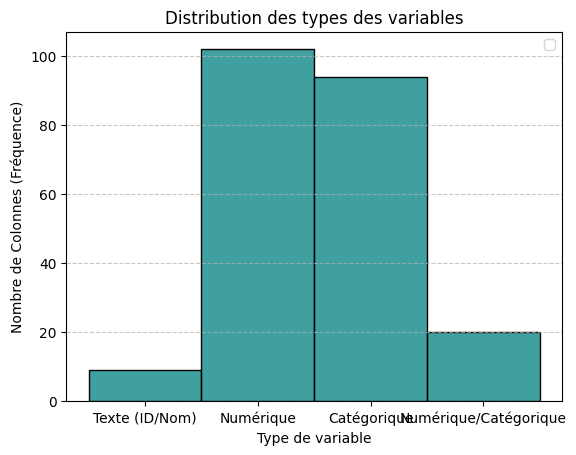

In [190]:
sns.histplot(df_profil['Classe Inférencée'], bins=20, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

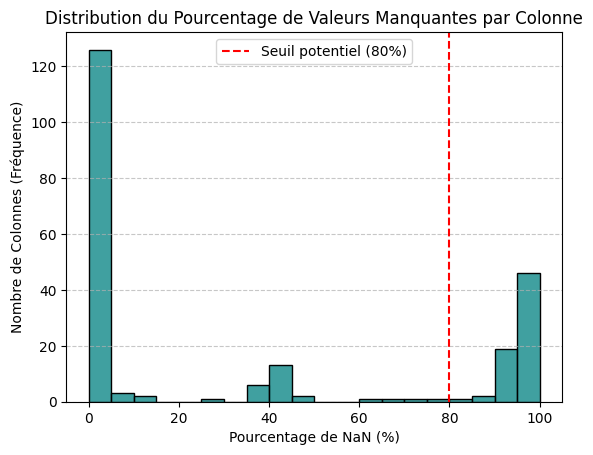

In [191]:
sns.histplot(df_profil['Valeurs Manquantes (%)'], bins=20,  color='teal')
SEUIL_VISUEL = 80
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Colonne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [192]:
#Retirer les colonnes où il manque le plus de valeurs

lst=df_profil[df_profil['Valeurs Manquantes (%)']>78].index.values.tolist()
print(len(lst))

dpe_dep_clean1=dpe_dep.copy().drop(columns=lst)

dpe_dep_clean1

68


,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,surface_habitable_immeuble,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,...,logement_traversant,indicateur_confort_ete,inertie_lourde,qualite_isolation_plancher_haut_toit_terrasse,nombre_niveau_immeuble,appartement_non_visite,numero_dpe_immeuble_associe,complement_adresse_batiment,provenance_id_rnb,id_rnb
0,Installation de chauffage simple,3506.6,Réseau de chaleur isolé,50,0.66,23551.0,932.1,14.2,17.6,405.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Installation de chauffage simple,6044.4,Chaudière gaz à condensation 2001-2015,74,0.80,NaN,506.3,35.5,21.0,14.0,...,0.0,insuffisant,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Installation de chauffage simple,17567.8,Chaudière gaz classique avant 1981,29,0.68,NaN,464.6,62.5,71.8,202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Installation de chauffage simple,3838.1,Chaudière gaz standard 1991-2000,53t,0.65,4840.0,602.7,25.8,24.1,262.0,...,1.0,insuffisant,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Installation de chauffage simple,40734.6,Chaudière gaz à condensation 2001-2015,37,0.67,NaN,1322.6,240.7,100.3,575.1,...,1.0,insuffisant,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529995,Installation de chauffage simple,2414.4,Chaudière gaz à condensation après 2015,7,0.67,1224.0,410.2,10.1,16.4,178.4,...,0.0,moyen,0.0,NaN,NaN,NaN,NaN,24/IMO/2387,Reprise RNB,X8F14PADQBTQ
529996,Installation de chauffage simple,3584.3,Ballon électrique à accumulation horizontal,34,0.66,NaN,0.0,13.8,11.1,0.0,...,1.0,insuffisant,0.0,NaN,NaN,NaN,NaN,2024/09/SJP/24694,NaN,NaN
529997,Installation de chauffage simple,59323.7,Réseau de chaleur isolé,11,0.69,6358.0,895.6,5342.9,33.9,389.4,...,NaN,NaN,NaN,insuffisante,18.0,1.0,2575E0070723E,DPESAB07700120240311,NaN,NaN
529998,Installation de chauffage simple,3337.6,Chaudière gaz à condensation 2001-2015,3,0.63,3993.0,1298.8,583.9,66.9,564.7,...,NaN,NaN,NaN,très bonne,6.0,1.0,2475E2699416S,015013B0911_DPE_20240630,Reprise RNB,EVBWQX6WMPD7


In [193]:
#Supprimer les noms de colonnes à plus de 80% de valeurs manquantes dans df_profil

df_profil=df_profil.drop(lst)

df_profil


,Type de Variable,Valeurs Manquantes (Count),Valeurs Manquantes (%),Nombre de Catégories Uniques,Classe Inférencée
numero_dpe,object,0,0.000000,530000,Texte (ID/Nom)
_id,object,0,0.000000,530000,Texte (ID/Nom)
_i,int64,0,0.000000,530000,Numérique
_rand,int64,0,0.000000,411328,Numérique
complement_adresse_logement,object,76801,14.490755,212344,Texte (ID/Nom)
...,...,...,...,...,...
inertie_lourde,float64,190211,35.888868,2,Numérique/Catégorique
appartement_non_visite,float64,373933,70.553396,2,Numérique/Catégorique
code_region_ban,object,0,0.000000,1,Catégorique
modele_dpe,object,0,0.000000,1,Catégorique


C:\Users\User\AppData\Local\Temp\ipykernel_7732\2022057862.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


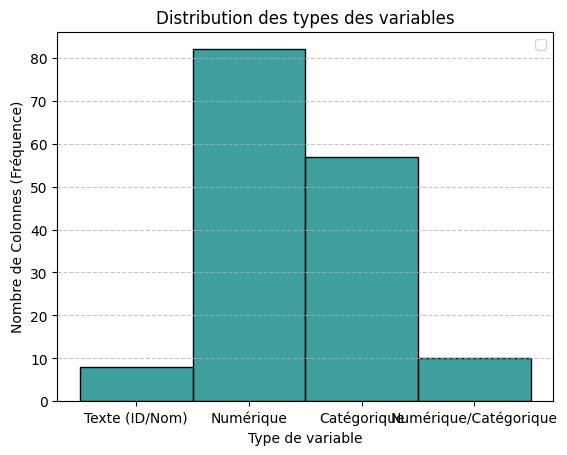

In [194]:
sns.histplot(df_profil['Classe Inférencée'], bins=30, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [195]:
#Transformer les colonnes avec des valeurs catégorielles avec moins de 15 possibilités str en catégories chiffrées 

lst_2=df_profil.loc[(df_profil['Classe Inférencée'].str.contains('Catégorique'))&
(df_profil['Nombre de Catégories Uniques']<=15)&
(df_profil['Type de Variable']=='object')].index.values.tolist()


def replace_cat(col_name,df):
    lst_values = sorted(df[col_name].dropna().astype(str).unique())
    
    # Crée le dictionnaire de mappage {Ancienne Valeur: Nouvel Entier}
    mapping_dict = {value: index + 1 for index, value in enumerate(lst_values)}
    
    # Applique le mappage en une seule opération vectorisée.
    df[col_name] = df[col_name].replace(mapping_dict)

    df[col_name] = df[col_name].astype('float64')
        
    print(col_name,df.dtypes[col_name])
    return df

print(len(dpe_dep_clean1.columns))
dpe_dep_clean2=dpe_dep_clean1.copy()
for i in lst_2 :
    dpe_dep_clean2=replace_cat(i,dpe_dep_clean2)


157
type_energie_principale_chauffage float64
type_energie_n1 float64
type_energie_n2 float64
type_energie_generateur_n1_installation_n1 float64
type_energie_principale_ecs float64
periode_construction float64
zone_climatique float64
type_energie_generateur_n1_ecs_n1 float64
configuration_installation_chauffage_n1 float64
etiquette_dpe float64
etiquette_ges float64
methode_application_dpe float64
type_installation_solaire_n1 float64
qualite_isolation_plancher_haut_comble_perdu float64
classe_inertie_batiment float64
qualite_isolation_plancher_haut_toit_terrasse float64
classe_altitude float64
usage_generateur_n1_installation_n1 float64
type_installation_chauffage_n1 float64
qualite_isolation_enveloppe float64
qualite_isolation_menuiseries float64
qualite_isolation_plancher_bas float64
qualite_isolation_murs float64
type_installation_chauffage float64
configuration_installation_ecs_n1 float64
type_batiment float64
indicateur_confort_ete float64
type_installation_ecs_n1 float64
type_inst

In [196]:
df_profil2 = profile_dataframe(dpe_dep_clean2)

# 3. Affichage du résultat
print("="*60)
print("Analyse de Profil du DataFrame :")
print("="*60)
print(df_profil2)
print("\n")

Analyse de Profil du DataFrame :
                            Type de Variable  Valeurs Manquantes (Count)  \
_id                                   object                           0   
_i                                     int64                           0   
numero_dpe                            object                           0   
_rand                                  int64                           0   
complement_adresse_logement           object                       76801   
...                                      ...                         ...   
presence_brasseur_air                float64                      186284   
provenance_id_rnb                    float64                      213363   
code_region_ban                      float64                           0   
modele_dpe                           float64                           0   
code_departement_ban                 float64                           0   

                             Valeurs Manquantes (%)  \

C:\Users\User\AppData\Local\Temp\ipykernel_7732\656681079.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


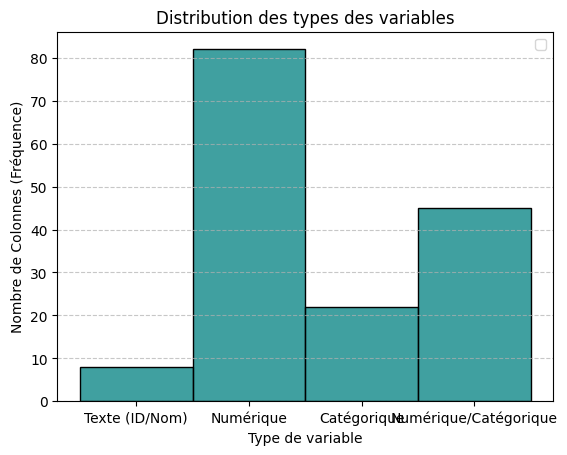

In [197]:
sns.histplot(df_profil2['Classe Inférencée'], bins=30, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [198]:
dpe_dep_clean2

,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,surface_habitable_immeuble,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,...,logement_traversant,indicateur_confort_ete,inertie_lourde,qualite_isolation_plancher_haut_toit_terrasse,nombre_niveau_immeuble,appartement_non_visite,numero_dpe_immeuble_associe,complement_adresse_batiment,provenance_id_rnb,id_rnb
0,8.0,3506.6,Réseau de chaleur isolé,50,0.66,23551.0,932.1,14.2,17.6,405.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.0,6044.4,Chaudière gaz à condensation 2001-2015,74,0.80,NaN,506.3,35.5,21.0,14.0,...,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,17567.8,Chaudière gaz classique avant 1981,29,0.68,NaN,464.6,62.5,71.8,202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,3838.1,Chaudière gaz standard 1991-2000,53t,0.65,4840.0,602.7,25.8,24.1,262.0,...,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,40734.6,Chaudière gaz à condensation 2001-2015,37,0.67,NaN,1322.6,240.7,100.3,575.1,...,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529995,8.0,2414.4,Chaudière gaz à condensation après 2015,7,0.67,1224.0,410.2,10.1,16.4,178.4,...,0.0,3.0,0.0,NaN,NaN,NaN,NaN,24/IMO/2387,2.0,X8F14PADQBTQ
529996,8.0,3584.3,Ballon électrique à accumulation horizontal,34,0.66,NaN,0.0,13.8,11.1,0.0,...,1.0,2.0,0.0,NaN,NaN,NaN,NaN,2024/09/SJP/24694,NaN,NaN
529997,8.0,59323.7,Réseau de chaleur isolé,11,0.69,6358.0,895.6,5342.9,33.9,389.4,...,NaN,NaN,NaN,2.0,18.0,1.0,2575E0070723E,DPESAB07700120240311,NaN,NaN
529998,8.0,3337.6,Chaudière gaz à condensation 2001-2015,3,0.63,3993.0,1298.8,583.9,66.9,564.7,...,NaN,NaN,NaN,4.0,6.0,1.0,2475E2699416S,015013B0911_DPE_20240630,2.0,EVBWQX6WMPD7


**Distribution du taux de NaN par ligne**

In [199]:
def analyze_nan_by_row(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le nombre et le pourcentage de NaN pour chaque ligne d'un DataFrame.

    Args:
        df: Le DataFrame pandas à analyser.

    Returns:
        Le DataFrame original avec deux nouvelles colonnes d'analyse.
    """
    

    # 1. Calcul du nombre de NaN par ligne
    df['nan_count_ligne'] = df.isnull().sum(axis=1)

    # 2. Calcul du pourcentage de NaN par ligne
    df['nan_pourcentage_ligne'] = (df['nan_count_ligne'] / (len(df.columns) - 1)) * 100

    return df

In [200]:
dpe_dep_clean2_bis=analyze_nan_by_row(dpe_dep_clean2.copy())

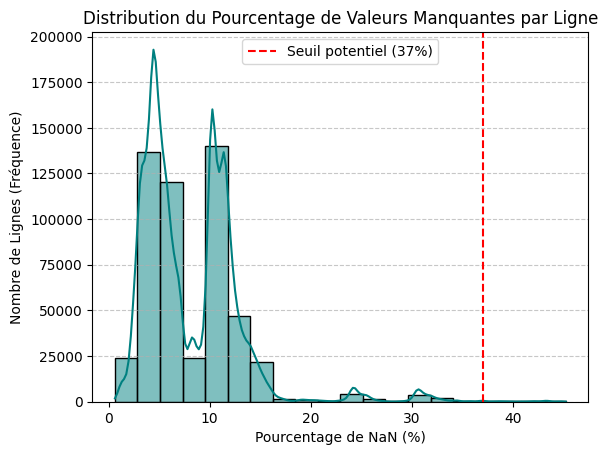

In [201]:
sns.histplot(dpe_dep_clean2_bis['nan_pourcentage_ligne'], bins=20, kde=True, color='teal')
SEUIL_VISUEL = 37
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Ligne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Lignes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

**Fonction retirer les lignes avec un certain pourcentage de valeurs manquante**

In [202]:
def drop_rows_by_na_threshold(df: pd.DataFrame, threshold_percent) -> pd.DataFrame:
    """
    Supprime les lignes d'un DataFrame dont le pourcentage de valeurs 
    manquantes (NaN) est supérieur ou égal au seuil spécifié.

    Args:
        df: Le DataFrame pandas à nettoyer.
        threshold_percent: Le seuil de NaN à ne pas dépasser (en pourcentage, ex: 30 pour 30%).

    Returns:
        Un nouveau DataFrame nettoyé.
    """
    
    # 1. Calculer le nombre minimal de valeurs NON-MANQUANTES (valides)
    # Le seuil est appliqué au nombre de valeurs présentes, pas au nombre de NaN.
    
    # Calculer le ratio de valeurs NON-manquantes
    valid_ratio = 1 - (threshold_percent / 100)
    
    # Calculer le nombre minimum de valeurs non-NaN requises par ligne
    min_valid_count = int(np.floor(len(df.columns) * valid_ratio))
    
    # Si le seuil est 0, on garde tout le monde (sauf si on enlève les lignes vides)
    if threshold_percent == 100:
        min_valid_count = 1 # Garde toute ligne qui a au moins 1 valeur non-NaN

    print(f"Nombre total de colonnes : {len(df.columns)}")
    print(f"Seuil de NaN max autorisé : {threshold_percent}%")
    print(f"Nombre MINIMAL de valeurs valides requises par ligne : {min_valid_count}")
    
    # 2. Appliquer la suppression avec .dropna(thresh=...)
    # On crée une copie pour ne pas modifier le DataFrame original passé en argument
    df_cleaned = df.copy().dropna(axis=0, thresh=min_valid_count)
    
    lignes_supprimees = len(df) - len(df_cleaned)
    print(f"Lignes supprimées : {lignes_supprimees} (soit {lignes_supprimees/len(df)*100:.2f}%)")
    
    return df_cleaned

In [203]:
#Retirer les lignes avec plus de 90% de valeurs manquantes 

dpe_dep_clean3 = drop_rows_by_na_threshold(dpe_dep_clean2,37)
dpe_dep_clean1 = drop_rows_by_na_threshold(dpe_dep_clean1,37) # on retire aussi dans le dataframe où il reste des catégories de type object

Nombre total de colonnes : 157
Seuil de NaN max autorisé : 37%
Nombre MINIMAL de valeurs valides requises par ligne : 98
Lignes supprimées : 705 (soit 0.13%)
Nombre total de colonnes : 157
Seuil de NaN max autorisé : 37%
Nombre MINIMAL de valeurs valides requises par ligne : 98
Lignes supprimées : 705 (soit 0.13%)


C:\Users\User\AppData\Local\Temp\ipykernel_7732\3294353298.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


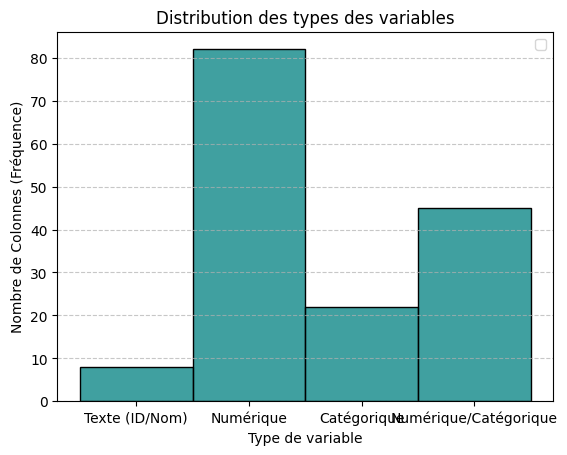

In [204]:
df_profil3=profile_dataframe(dpe_dep_clean3)

sns.histplot(df_profil3['Classe Inférencée'], bins=30, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [205]:
lst_3=df_profil3.loc[df_profil3['Classe Inférencée'].isin(['object','Texte (ID/Nom)','Date/Heure','Catégorique'])].index.values.tolist()
print(len(lst_3))

dpe_dep_clean_corr= dpe_dep_clean3.copy().drop(columns=lst_3)
std_dev = dpe_dep_clean_corr.std()
dpe_dep_clean_corr= dpe_dep_clean_corr.copy().drop(columns=std_dev[std_dev < 1e-6].index.tolist())
print(len(dpe_dep_clean_corr.columns))

# Vérifier l'existence des colonnes avant la sélection pour éviter KeyError
_cols_to_show = [c for c in ['appartement_non_visite', 'classe_altitude'] if c in dpe_dep_clean_corr.columns]
if _cols_to_show:
    # Afficher les colonnes demandées (au format 'head' pour éviter de surcharger la sortie)
    print(f"Colonnes trouvées : {_cols_to_show}")
    display(dpe_dep_clean_corr[_cols_to_show].head())
else:
    missing = [c for c in ['appartement_non_visite', 'classe_altitude'] if c not in dpe_dep_clean_corr.columns]
    print(f"Colonnes manquantes : {missing}. Elles ne sont pas présentes dans le DataFrame.")

30
124
Colonnes trouvées : ['appartement_non_visite', 'classe_altitude']


,appartement_non_visite,classe_altitude
0,NaN,3.0
1,NaN,3.0
2,NaN,3.0
3,NaN,3.0
4,NaN,3.0


In [206]:
masque_nan = dpe_dep_clean_corr.corr().isnull()

nan_locations = masque_nan[masque_nan].stack()

liste_index_colonne_nan = nan_locations.index.tolist()
liste_index_colonne_nan= set([tuple(sorted(paire)) for paire in liste_index_colonne_nan])

lst_col=[]
for i in liste_index_colonne_nan:
    lst_col.append(i[0])
    lst_col.append(i[1])

dpe_dep_clean_corr=dpe_dep_clean_corr.drop(columns=lst_col)

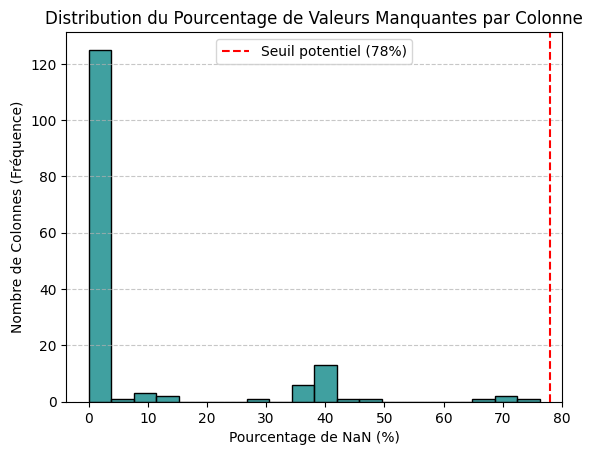

In [207]:
sns.histplot(df_profil3['Valeurs Manquantes (%)'], bins=20,  color='teal')
SEUIL_VISUEL = 78
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Colonne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

**Analyse Descriptive**

In [208]:
dpe_dep_clean1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529295 entries, 0 to 529999
Columns: 157 entries, configuration_installation_chauffage_n1 to id_rnb
dtypes: float64(88), int64(4), object(65)
memory usage: 638.0+ MB


<Axes: >

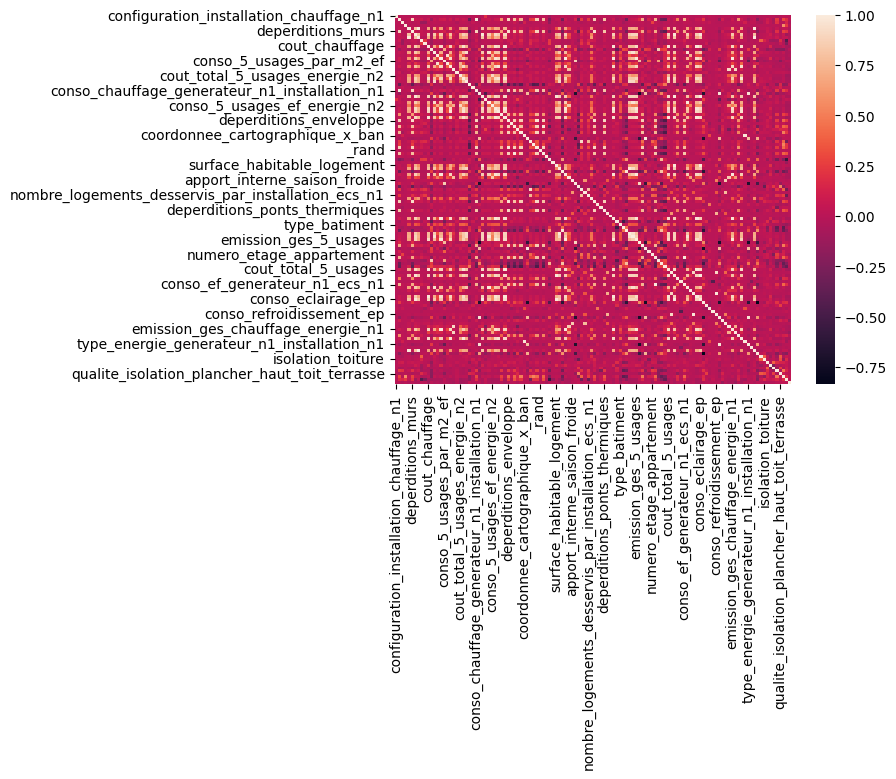

In [209]:
sns.heatmap(dpe_dep_clean_corr.corr())


In [210]:
total_nan = dpe_dep_clean_corr.corr().isnull().sum().sum()
total_nan

np.int64(0)

c:\Users\User\OneDrive\Bureau\Projet Capstone\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\User\OneDrive\Bureau\Projet Capstone\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


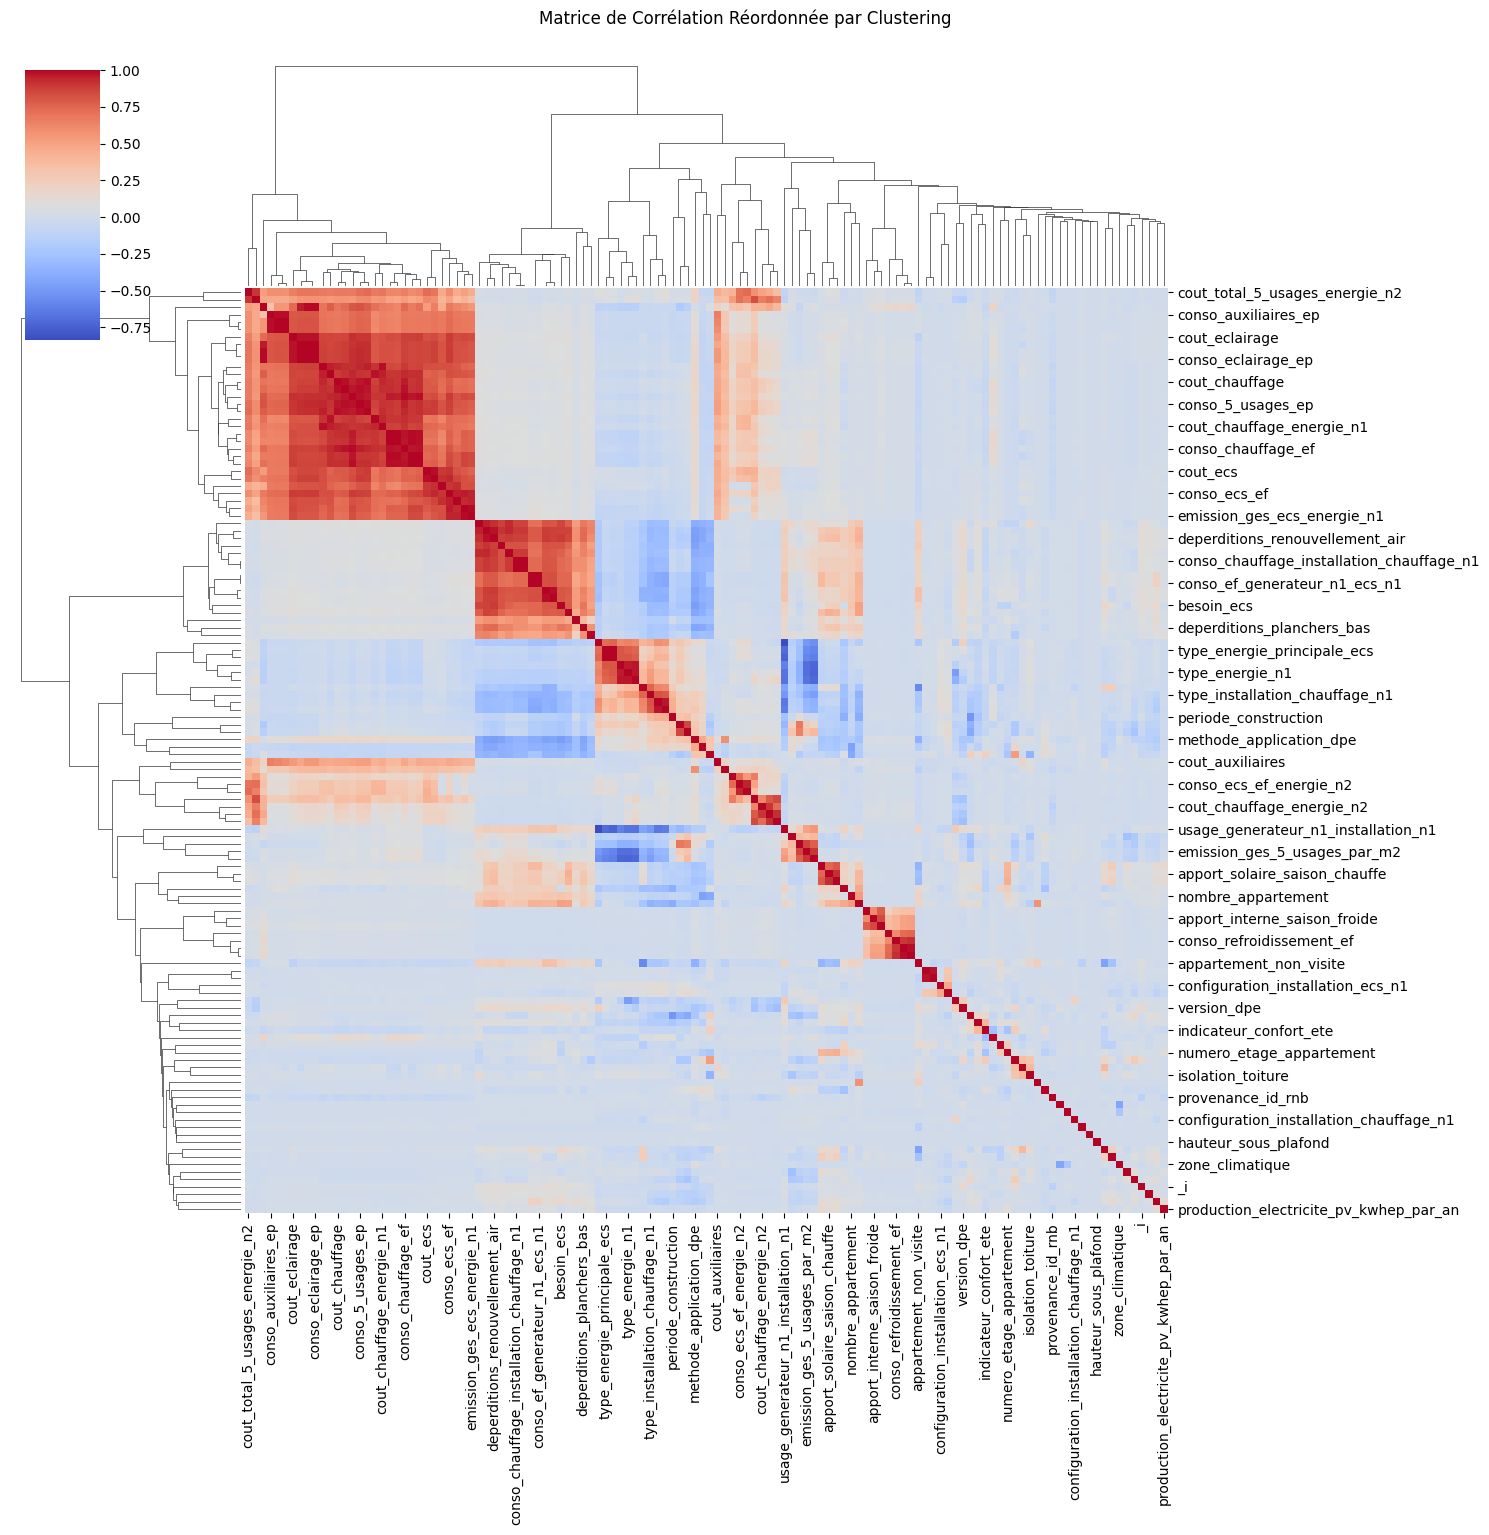

In [211]:
sns.clustermap(
    dpe_dep_clean_corr.corr(),
    figsize=(15, 15),       
    cmap='coolwarm',
    annot=False             
)
plt.suptitle("Matrice de Corrélation Réordonnée par Clustering", y=1.02)
plt.savefig(
    'mon_graphique_corr.png',  # 1. Nom du fichier et format (PNG, PDF, JPG, etc.)
    dpi=300,                   # 2. Résolution (300 dpi est bon pour l'impression)
    bbox_inches='tight'        # 3. Supprime l'espace blanc inutile autour du graphique
)
plt.show()

**Normalisation des données**

In [212]:
#std_dpe_dep= (dpe_dep_clean1-dpe_dep_clean1.mean())/dpe_dep_clean1.std()

In [213]:
def plot_dpe_distribution(df: pd.DataFrame, dpe_col: str):
    """
    Affiche un histplot de la distribution DPE en utilisant les couleurs officielles.
    """
    
    # Couleurs officielles DPE (Vert clair à Rouge)
    DPE_COLORS = [
        '#FDE724', '#A0DA39', '#4AC16D', '#1FA187', 
        '#277F8E', '#365C8D', '#440154'
    ]
    
    # Assurez-vous que les catégories sont triées (A, B, C, D, E, F, G)
    # et que la colonne est de type 'category' pour le bon ordre.
    # On ajoute np.nan dans la liste des catégories pour éviter les avertissements, 
    # même s'il ne sera pas affiché.
    dpe_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    # Nettoyage et tri : Remplir les NaN pour qu'ils soient ignorés ou traités séparément
    df_plot = df.copy()
    
    # 1. Convertir en type catégoriel avec l'ordre défini
    df_plot[dpe_col] = pd.Categorical(
        df_plot[dpe_col], 
        categories=dpe_order, 
        ordered=True
    )
    
    # 2. Filtrer les NaN pour l'affichage (sinon ils sont regroupés dans une barre à part)
    df_plot = df_plot.dropna(subset=[dpe_col]) 

    plt.figure(figsize=(10, 6))
    
    sns.histplot(
        data=df_plot,
        x=dpe_col,                  # Axe X : la catégorie DPE
        hue=dpe_col,                # Hue : la couleur par catégorie DPE
        palette=DPE_COLORS,         # Palette : Utilisation des couleurs personnalisées
        stat="count",               # Montre le nombre d'occurrences
        legend=False,               # La légende n'est pas nécessaire car les barres sont colorées
        shrink=0.8                  # Réduit la taille des barres pour la lisibilité
    )

    plt.title(f'Distribution des Diagnostics de Performance Énergétique ({dpe_col})')
    plt.xlabel('Classe DPE')
    plt.ylabel('Nombre de Biens')

    plt.savefig(
        'dist_dpe.png',  # 1. Nom du fichier et format (PNG, PDF, JPG, etc.)
        dpi=300,                   # 2. Résolution (300 dpi est bon pour l'impression)
        bbox_inches='tight'        # 3. Supprime l'espace blanc inutile autour du graphique
    )
    plt.show()

    

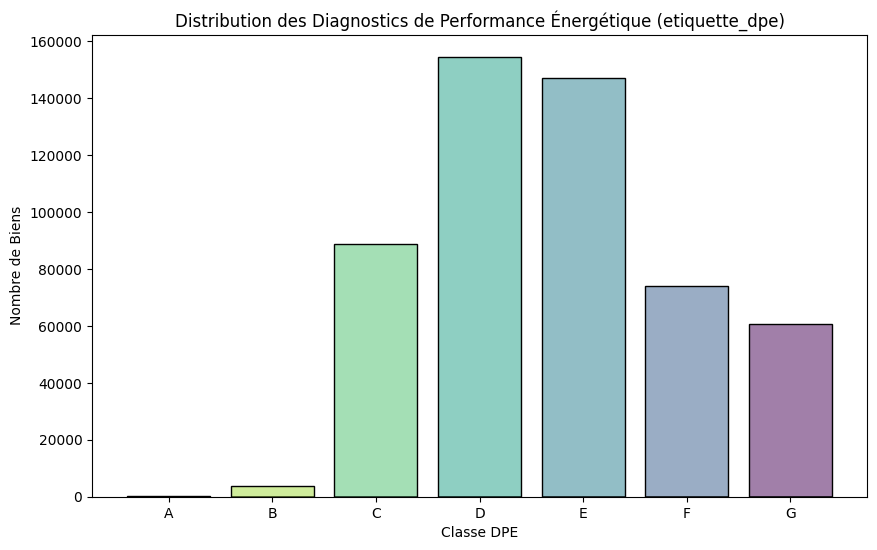

In [214]:
plot_dpe_distribution(dpe_dep_clean1,'etiquette_dpe')

In [215]:
def plot_dpe_evolution_by_period(df: pd.DataFrame, dpe_col: str, period_col: str):
    """
    Affiche l'évolution du DPE en fonction de la période de construction (diagramme empilé normalisé).

    Args:
        df: DataFrame contenant les données.
        dpe_col: Nom de la colonne contenant les étiquettes DPE (A à G).
        period_col: Nom de la colonne contenant les périodes de construction.
    """
    
    # 1. Définir les Couleurs et l'Ordre
    # Couleurs officielles DPE (Vert A à Rouge G)
    DPE_COLORS = [
        '#FDE724', '#A0DA39', '#4AC16D', '#1FA187', 
        '#277F8E', '#365C8D', '#440154'
    ]
    DPE_ORDER = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    df_plot = df.copy().dropna(subset=[dpe_col, period_col])
    
    # Assurer que la colonne DPE est triée pour que les couleurs correspondent
    df_plot[dpe_col] = pd.Categorical(df_plot[dpe_col], categories=DPE_ORDER, ordered=True)
    
    # 2. Préparation des Données (Calcul des Proportions)
    
    # Calculer le nombre d'occurrences pour chaque combinaison Période/DPE
    df_counts = df_plot.groupby([period_col, dpe_col]).size().unstack(fill_value=0)
    
    # Normaliser les comptes pour obtenir des pourcentages (la somme de chaque ligne = 1)
    df_proportions = df_counts.div(df_counts.sum(axis=1), axis=0)
    
    # 3. Affichage du Graphique
    
    plt.figure(figsize=(12, 7))
    
    # Utilisation de la méthode .plot(kind='bar', stacked=True) sur le DataFrame de proportions
    ax = df_proportions.plot(
        kind='bar', 
        stacked=True, 
        color=DPE_COLORS, 
        ax=plt.gca() # Utiliser l'objet figure créé
    )

    # Mise en forme
    plt.title("Évolution de la Distribution des Étiquettes DPE par Période de Construction", fontsize=14)
    plt.xlabel("Période de Construction")
    plt.ylabel("Proportion de Biens (100%)")
    plt.xticks(rotation=45, ha='right')
    
    # Placer la légende à l'extérieur
    ax.legend(
        title='Classe DPE', 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        borderaxespad=0.
    )
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(
        'evo_dpe.png',  # 1. Nom du fichier et format (PNG, PDF, JPG, etc.)
        dpi=300,                   # 2. Résolution (300 dpi est bon pour l'impression)
        bbox_inches='tight'        # 3. Supprime l'espace blanc inutile autour du graphique
    )
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_7732\1580863598.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df_plot.groupby([period_col, dpe_col]).size().unstack(fill_value=0)


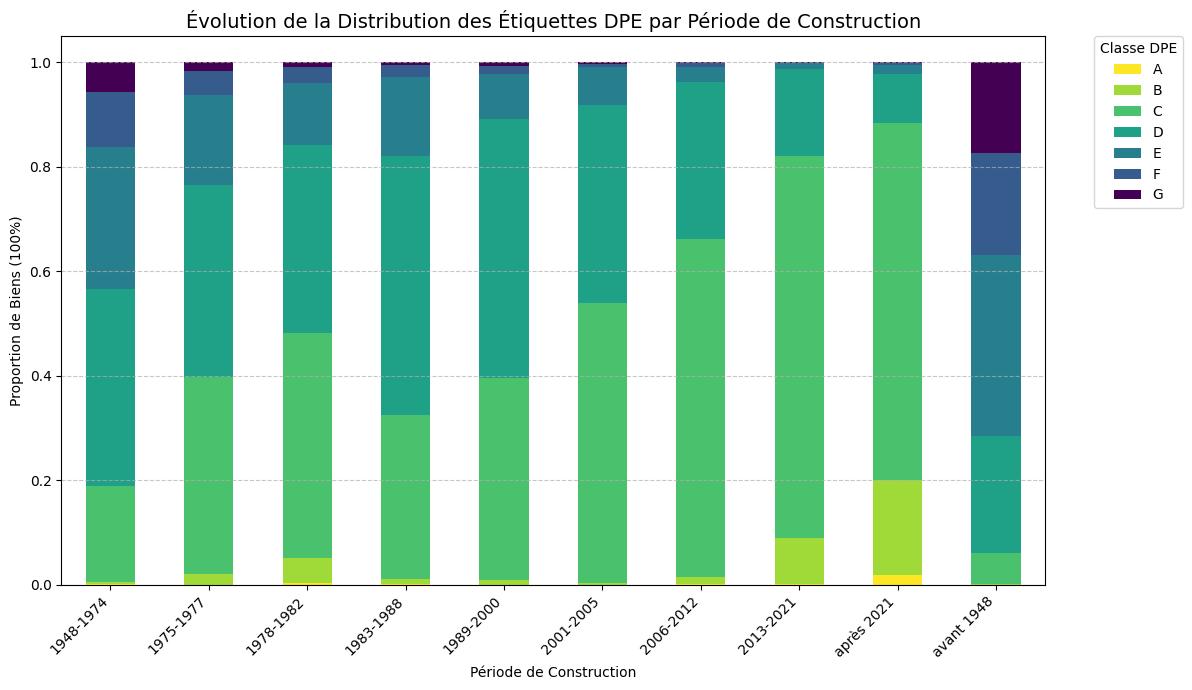

In [216]:
plot_dpe_evolution_by_period(dpe_dep_clean1,'etiquette_dpe','periode_construction')

In [217]:
dpe_dep_clean1['periode_construction'].unique()

ORDRE_PERIODES =[ 'Avant 1948', '1948-1974', '1975-1977','1978-1982',
        '1983-1988','1989-2000', '2001-2005','2006-2012', '2013-2021', 'Après 2021']

dpe_dep_clean1['periode_construction'] = pd.Categorical(
    dpe_dep_clean1['periode_construction'],
    categories=ORDRE_PERIODES,
    ordered=True # C'est crucial pour le tri dans les graphiques
)

In [218]:
def plot_dpe_percent_over_time(df: pd.DataFrame, dpe_col: str, time_col: str):
    """
    Affiche l'évolution du POURCENTAGE de biens pour chaque étiquette DPE 
    en fonction d'une colonne temporelle (Année de construction, etc.).
    """
    
    # --- 1. Préparation des Couleurs et de l'Ordre ---
    DPE_COLORS = [
        '#009647', '#78c253', '#c8da5d', '#f8e029', 
        '#f9b626', '#f18219', '#e40121'
    ]
    DPE_ORDER = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    df_plot = df.copy().dropna(subset=[dpe_col, time_col])
    df_plot[dpe_col] = pd.Categorical(df_plot[dpe_col], categories=DPE_ORDER, ordered=True)
    
    # --- 2. Agrégation des Données (Comptage) ---
    # a. Compter les occurrences par Année et par Classe DPE
    df_aggregated = df_plot.groupby([time_col, dpe_col]).size().reset_index(name='Nombre_de_Biens')
    
    # b. Calculer le total des biens par année
    total_par_annee = df_aggregated.groupby(time_col)['Nombre_de_Biens'].transform('sum')
    
    # c. Calculer le POURCENTAGE
    df_aggregated['Pourcentage'] = (df_aggregated['Nombre_de_Biens'] / total_par_annee) * 100
    
    # 3. Affichage du Graphique
    
    plt.figure(figsize=(14, 7))
    
    sns.lineplot(
        data=df_aggregated,
        x=time_col,                  # Axe X : La variable temporelle
        y='Pourcentage',             # Axe Y : Le pourcentage
        hue=dpe_col,                 # Le label qui définit la couleur de chaque courbe
        hue_order=DPE_ORDER,
        palette=DPE_COLORS,          # Utilisation des couleurs officielles
        linewidth=2.5
    )

    # Mise en forme
    plt.title(f"Évolution en Pourcentage des Étiquettes DPE par Année", fontsize=16)
    plt.xlabel(time_col)
    plt.ylabel("Pourcentage de Biens (%)")
    plt.legend(title='Classe DPE', loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(
        'evo_dpe.png',  # 1. Nom du fichier et format (PNG, PDF, JPG, etc.)
        dpi=300,                   # 2. Résolution (300 dpi est bon pour l'impression)
        bbox_inches='tight'        # 3. Supprime l'espace blanc inutile autour du graphique
    )
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_7732\3351528248.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aggregated = df_plot.groupby([time_col, dpe_col]).size().reset_index(name='Nombre_de_Biens')
C:\Users\User\AppData\Local\Temp\ipykernel_7732\3351528248.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_par_annee = df_aggregated.groupby(time_col)['Nombre_de_Biens'].transform('sum')


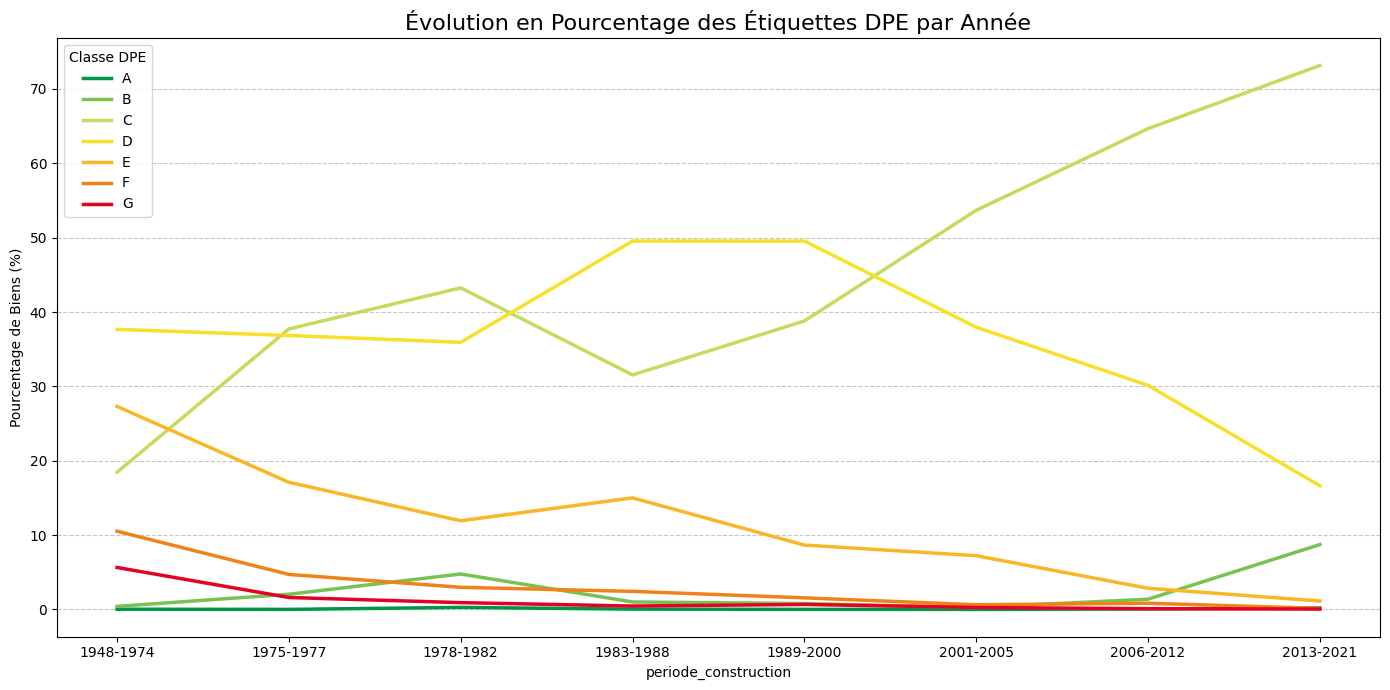

In [219]:
plot_dpe_percent_over_time(dpe_dep_clean1,'etiquette_dpe','periode_construction')
